In [1]:
import helper as h   # nasz moduł
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from tqdm import tqdm

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import eli5
import re

## Wczytujemy dane i łączymy je

Parsujemy też cenę i rozpakowujemy słownik

In [2]:
df_train = pd.read_hdf("../input/df.train.h5")
df_train["price_value"] = df_train['price_value'].map(h.parse_price)

df_test = pd.read_hdf("../input/df.test.h5")

print(df_train.shape, df_test.shape)

df = h.get_df(df_train, df_test)

(80129, 10) (80129, 7)
(160257, 86)


In [3]:
cat_feats = set(x for x in df.columns if "_cat" in x)
cat_feats

{'Acrylic_cat',
 'Akryl (niemetalizowany)_cat',
 'Bezwypadkowy_cat',
 'Body type_cat',
 'CO2 emissions_cat',
 'Color_cat',
 'Country of origin_cat',
 'Damaged_cat',
 'Door count_cat',
 'Emisja CO2_cat',
 'Engine Code_cat',
 'Engine capacity_cat',
 'Engine power_cat',
 'Faktura VAT_cat',
 'Filtr cząstek stałych_cat',
 'Financing option_cat',
 'First registration_cat',
 'Fuel type_cat',
 'Gearbox_cat',
 'Homologacja ciężarowa_cat',
 'Kategoria_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Kod Silnika_cat',
 'Kolor_cat',
 'Kraj pochodzenia_cat',
 'Leasing concession_cat',
 'Leasing_cat',
 'Liczba drzwi_cat',
 'Liczba miejsc_cat',
 'Liczba pozostałych rat_cat',
 'Make_cat',
 'Marka pojazdu_cat',
 'Matowy_cat',
 'Metalik_cat',
 'Metallic_cat',
 'Miesięczna rata_cat',
 'Mileage_cat',
 'Moc_cat',
 'Model pojazdu_cat',
 'Model_cat',
 'Monthly payment value_cat',
 'Możliwość finansowania_cat',
 'Napęd_cat',
 'No accident_cat',
 'Nr of seats_cat',
 'Oferta od_cat',
 'Opłata początkowa_cat',
 'Or

In [4]:
list(df.columns)

['id',
 'price_details',
 'price_value',
 'price_currency',
 'features',
 'seller_name',
 'seller_type',
 'seller_address',
 'breadcrumb',
 'offer_params',
 'Bezwypadkowy',
 'Liczba miejsc',
 'Kraj pochodzenia',
 'Pojemność skokowa',
 'Rodzaj paliwa',
 'Skrzynia biegów',
 'Możliwość finansowania',
 'Pierwszy właściciel',
 'Oferta od',
 'Liczba drzwi',
 'Przebieg',
 'Moc',
 'Metalik',
 'Typ',
 'Kolor',
 'Model pojazdu',
 'Stan',
 'Kategoria',
 'Serwisowany w ASO',
 'Napęd',
 'Leasing',
 'Rok produkcji',
 'Marka pojazdu',
 'Faktura VAT',
 'Pierwsza rejestracja',
 'Zarejestrowany w Polsce',
 'VAT marża',
 'Wersja',
 'VIN',
 'Perłowy',
 'Uszkodzony',
 'Kod Silnika',
 'Filtr cząstek stałych',
 'Emisja CO2',
 'Miesięczna rata',
 'Liczba pozostałych rat',
 'Opłata początkowa',
 'Wartość wykupu',
 'Akryl (niemetalizowany)',
 'Tuning',
 'Kierownica po prawej (Anglik)',
 'Homologacja ciężarowa',
 'Make',
 'Metallic',
 'Engine capacity',
 'Version',
 'VAT discount',
 'No accident',
 'Mileage',
 '

In [5]:
feats = cat_feats

## Moc silnika

Zmiana na inta, połączenie z angielskimi i podział na kategorie.

In [6]:
df["moc_int"] = df["Moc"].astype("str").map(lambda x: int(x.split("KM")[0].replace(" ", "")))
df["engine_power_int"] = df["Engine power"].astype("str").map(lambda x: int(x.split("HP")[0].replace(" ", "")))

df["moc_ext"] = df.apply(lambda x : x["moc_int"] if x["moc_int"] != -1 else x["engine_power_int"], axis=1)

# df["moc_ext_cat"] = pd.qcut(df["moc_ext"], 10, labels=False)

# feats = cat_feats | {"moc_ext_cat"}
# feats.discard("Moc_cat")

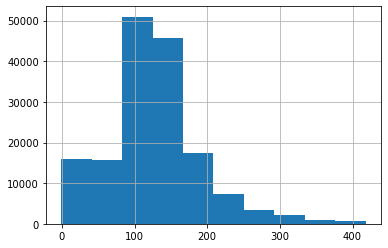

In [7]:
# df.moc_int.hist()

h.reset_outliers(df, "moc_ext").hist()

df["moc_ext_99"] = h.reset_outliers(df, "moc_ext")

feats.add("moc_ext_99")
feats.discard("moc_cat")

## Rok produkcji

Zmiana na inta

In [8]:
df["rok_produkcji_int"] = df["Rok produkcji"].astype(int)

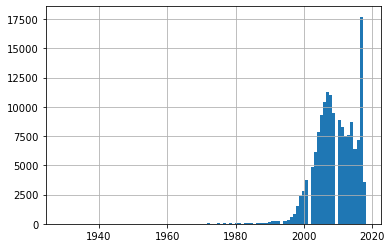

In [9]:
df[ df["rok_produkcji_int"] != -1 ]["rok_produkcji_int"].hist(bins=100);

Scalenie kolumn rok produkcji i year

In [10]:
pd.crosstab(df["rok_produkcji_int"], df.Year)
df[ df["rok_produkcji_int"] == -1 ][["rok_produkcji_int", "Year"]]

,rok_produkcji_int,Year
314,-1,2006
466,-1,2012
601,-1,2007
3214,-1,2014
3543,-1,2007
...,...,...
143347,-1,2005
148522,-1,2017
149537,-1,2008
155387,-1,2017


In [11]:
df["rok_produkcji_ext"] = df.apply(
    lambda x: x["rok_produkcji_int"] if x["rok_produkcji_int"] != -1 else int(x["Year"]), axis=1
)

feats.discard("Rok produkcji_cat")
feats.add("rok_produkcji_ext")

## Pojemność skokowa (cylindra)

In [12]:
df["Pojemność skokowa"].nunique()
pd.pivot_table(df, index=["Pojemność skokowa"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len])

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
-1,42474.725,19500.000,650.000,760000.000,7581.000
1 000 cm3,33535.686,28500.000,699.000,96980.000,1751.000
1 043 cm3,2839.600,1700.000,999.000,7500.000,5.000
1 046 cm3,39000.000,39000.000,39000.000,39000.000,3.000
1 049 cm3,12800.000,12800.000,12800.000,12800.000,1.000
...,...,...,...,...,...
896 cm3,nan,nan,nan,nan,1.000
9 000 cm3,nan,nan,nan,nan,1.000
903 cm3,nan,nan,nan,nan,1.000


In [13]:
df["poj_skokowa_int"] = df["Pojemność skokowa"].astype("str").map(lambda x: int(x.split("cm3")[0].replace(" ", "")))
# df["poj_skokowa_int_cat"] = pd.qcut(df["poj_skokowa_int"],5, labels = False)

# df["poj_skokowa_int_cat"]

# feats.add("poj_skokowa_int_cat")
# feats.discard("Pojemność skokowa_cat")

AxesSubplot(0.125,0.125;0.775x0.755)


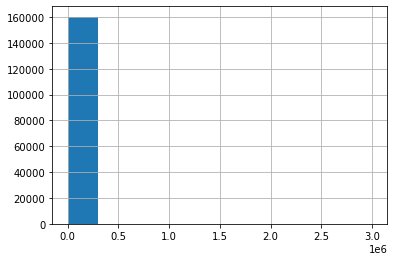

In [14]:
print(df["poj_skokowa_int"].hist())

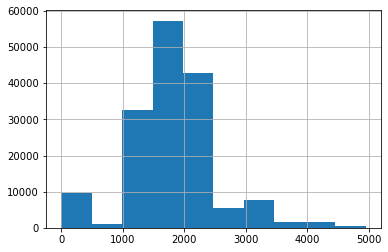

In [15]:
h.reset_outliers(df, "poj_skokowa_int").hist()

df["poj_skokowa_int_99"] = h.reset_outliers(df, "poj_skokowa_int")

feats.add("poj_skokowa_int_99")
feats.discard("Pojemność skokowa_cat")

## Wersja

Wydobycie lat

In [16]:
df["Wersja"].head()

0                -1
1                -1
2     H (2004-2014)
3    B8 (2007-2015)
4       Mk7 (2008-)
Name: Wersja, dtype: object

In [17]:
df["version_years"] = df["Wersja"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)))

df.version_years.head()

0                []
1                []
2    [(2004, 2014)]
3    [(2007, 2015)]
4        [(2008, )]
Name: version_years, dtype: object

In [18]:
df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

df[ ["version_year_from", "version_year_to"] ].head()

,version_year_from,version_year_to
0,-1,-1
1,-1,-1
2,2004,2014
3,2007,2015
4,2008,-1


In [19]:
feats.discard("Wersja_cat")
feats = feats | {"version_year_from", "version_year_to"}

#TODO dodać bliźniaczą kolumnę "Version"

## Przebieg

In [20]:
df[df['Mileage'] != -1]['Mileage']

314       122 300 km
466       123 900 km
601       262 000 km
3214      136 000 km
3543      230 786 km
             ...    
143347    207 000 km
148522        100 km
149537    268 000 km
155387     10 297 km
158263     91 500 km
Name: Mileage, Length: 127, dtype: object

In [21]:
df["Przebieg"].nunique()
pd.pivot_table(df, index=["Przebieg"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len])

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
-1,191738.072,107045.000,2900.000,2193400.000,534.000
0 km,4300.000,4300.000,4300.000,4300.000,1.000
1 000 000 km,27533.167,7200.000,3900.000,124999.000,8.000
1 000 km,159192.634,121200.000,2600.000,779000.000,132.000
1 012 km,61900.000,61900.000,61900.000,61900.000,1.000
...,...,...,...,...,...
99 989 km,nan,nan,nan,nan,2.000
99 990 km,nan,nan,nan,nan,2.000
99 995 km,nan,nan,nan,nan,1.000


In [22]:
df["Przebieg_int"] = df["Przebieg"].astype("str").map(lambda x: int(x.split("km")[0].replace(" ", "")))
df["Mileage_int"] = df["Mileage"].astype("str").map(lambda x: int(x.split("km")[0].replace(" ", "")))
df["przebieg_ext"] = df.apply(
    lambda x: x["Przebieg_int"] if x["Przebieg_int"] != -1 else int(x["Mileage_int"]), axis=1
)
# df["Przebieg_int_cat"] = pd.qcut(df["Przebieg_int"], 10, labels=False)

# feats.discard("Przebieg_cat")
# feats.add("Przebieg_int_cat")

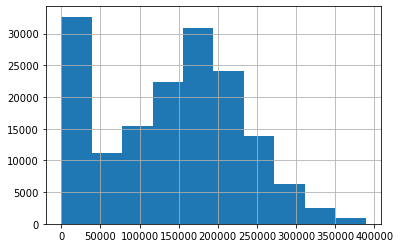

In [23]:
df.Przebieg_int.value_counts()

h.reset_outliers(df, "przebieg_ext",99.5).hist()

df["przebieg_ext_99"] = h.reset_outliers(df, "przebieg_ext", 99.5)

feats.add("przebieg_ext_99")
feats.discard("Przebieg_cat")

## Skrzynia biegów

Połącznenie angielskiej i polskiej kategorii (ponieważ cecha "skrzynia biegów" jest często używana przez algorytm)

Nazwy w kolumnie gearbox i tak są po polsku.

In [24]:
df[df.Gearbox != -1] ["Gearbox"]. sample(5)

25258                           Manualna
43901                           Manualna
72455    Automatyczna bezstopniowa (CVT)
63634                           Manualna
93446                           Manualna
Name: Gearbox, dtype: object

In [25]:
df["skrzynia_biegow_ext"] = df.apply(
    lambda x: x['Skrzynia biegów'] if x['Skrzynia biegów'] != -1 else x["Gearbox"], axis=1
)

df["skrzynia_biegow_ext_cat"] = df["skrzynia_biegow_ext"].factorize()[0]

feats.discard("Skrzynia biegów_cat")
feats.discard("Gearbox_cat")
feats.add("skrzynia_biegow_ext_cat")


## Miesięczna rata

zmiana na inta i kategoryzacja

In [26]:
df['rata_int'] = df['Miesięczna rata'].astype("str").map(
    lambda x: float(x.split("PLN")[0].replace(" ", "").replace(',', '.'))
)

df['rata_int_cat'] = pd.cut(df['rata_int'], 10, labels=False)  #FIX: jest problem z ilością kategorii, bo jest wiele wartości -1
# nie wiem co z tym zrobić

feats.discard('Miesięczna rata_cat')
feats.add('rata_int_cat')

In [27]:
# df.rata_int.value_counts()
# h.reset_outliers(df, 'rata_int').hist()

## Zdekategoryzowanie intów

In [28]:
df["Liczba miejsc"] = df["Liczba miejsc"].astype(int)
df["Nr of seats"] = df["Nr of seats"].astype(int)
df["liczba_miejsc_ext"] = df.apply(
    lambda x: x['Liczba miejsc'] if x['Liczba miejsc'] != -1 else x["Nr of seats"], axis=1
)
feats.discard("Liczba miejsc_cat")
feats.add("liczba_miejsc_ext")

df["Liczba drzwi"] = df["Liczba drzwi"].astype(int)
df['Door count'] = df['Door count'].astype(int)
df["liczba_drzwi_ext"] = df.apply(
    lambda x: x["Liczba drzwi"] if x["Liczba drzwi"] != -1 else x['Door count'], axis=1
)

feats.discard("Liczba drzwi_cat")
feats.add("liczba_drzwi_ext")

## Usunięcie niepotrzebnych kategorii

In [29]:
feats.discard('Pierwsza rejestracja_cat')
feats.discard('VIN_cat')

In [30]:
feats

{'Acrylic_cat',
 'Akryl (niemetalizowany)_cat',
 'Bezwypadkowy_cat',
 'Body type_cat',
 'CO2 emissions_cat',
 'Color_cat',
 'Country of origin_cat',
 'Damaged_cat',
 'Door count_cat',
 'Emisja CO2_cat',
 'Engine Code_cat',
 'Engine capacity_cat',
 'Engine power_cat',
 'Faktura VAT_cat',
 'Filtr cząstek stałych_cat',
 'Financing option_cat',
 'First registration_cat',
 'Fuel type_cat',
 'Homologacja ciężarowa_cat',
 'Kategoria_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Kod Silnika_cat',
 'Kolor_cat',
 'Kraj pochodzenia_cat',
 'Leasing concession_cat',
 'Leasing_cat',
 'Liczba pozostałych rat_cat',
 'Make_cat',
 'Marka pojazdu_cat',
 'Matowy_cat',
 'Metalik_cat',
 'Metallic_cat',
 'Mileage_cat',
 'Moc_cat',
 'Model pojazdu_cat',
 'Model_cat',
 'Monthly payment value_cat',
 'Możliwość finansowania_cat',
 'Napęd_cat',
 'No accident_cat',
 'Nr of seats_cat',
 'Oferta od_cat',
 'Opłata początkowa_cat',
 'Original owner_cat',
 'Particle filter_cat',
 'Pearl_cat',
 'Perłowy_cat',
 'Pierwszy

In [31]:
# h.check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), cv=3)
feats_list = list(feats)

h.check_log_model(df, feats_list, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8466.723881901848, 184.84702607003675)


Weight,Feature
0.3938,rok_produkcji_ext
0.1727,Napęd_cat
0.1067,skrzynia_biegow_ext_cat
0.0471,moc_ext_99
0.0269,Serwisowany w ASO_cat
0.0265,Uszkodzony_cat
0.0215,Bezwypadkowy_cat
0.0201,Kierownica po prawej (Anglik)_cat
0.0161,poj_skokowa_int_99
0.0146,Typ_cat


In [32]:
df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats_list]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats_list]

# trenujemy model na zlogarytmizowanej cenie
model = xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_log_year_production.csv", index=False)

## #IDEAS

In [33]:
df[df['Miesięczna rata']!=-1]['Miesięczna rata'].sample(20)

df['Miesięczna rata'].value_counts()
# len(df[df['Miesięczna rata'] != -1])

-1              159531
400 PLN             27
600 PLN             21
500 PLN             15
700 PLN             13
                 ...  
853 PLN              1
1 034,15 PLN         1
1 023 PLN            1
843 PLN              1
813,09 PLN           1
Name: Miesięczna rata, Length: 534, dtype: int64

## Uwagi

 ~~'Bezwypadkowy_cat',~~ **'No accident_cat',**
 ~~'Kraj pochodzenia_cat',~~
 ~~'Rodzaj paliwa_cat',~~
 'Możliwość finansowania_cat',
 ~~'Pierwszy właściciel_cat',~~
 ~~'Oferta od_cat',~~ - firma/ osoba prywatna
 ~~'Metalik_cat', 'Metallic_cat',~~
 ~~'Typ_cat',~~
 ~~'Kolor_cat',~~
 'Model pojazdu_cat',
 ~~'Stan_cat',~~
 ~~'Kategoria_cat',~~ - osobowe
 ~~'Serwisowany w ASO_cat',~~
 'Napęd_cat',
 ~~'Leasing_cat',~~
 'Marka pojazdu_cat',
 ~~'Faktura VAT_cat',~~
 'Zarejestrowany w Polsce_cat',
 ~~'VAT marża_cat',  'VAT discount_cat',~~
 ~~'Perłowy_cat',~~
 ~~'Uszkodzony_cat',~~
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',   - mało wartości (413)
 'Wartość wykupu_cat',
 ~~'Akryl (niemetalizowany)_cat',~~
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 
 'Make_cat',
 'Service record_cat',
 'Fuel type_cat',

 'Transmission_cat',
 'Model_cat',
 'Color_cat',
 'Country of origin_cat',
 'Body type_cat',
 'Matowy_cat',
 'Acrylic_cat',
 'Financing option_cat',
 'Registered in Poland_cat',
 'Original owner_cat',
 'First registration_cat',
 'Pearl_cat',
 'Zarejestrowany jako zabytek_cat',
 'VAT free_cat',
 'Engine Code_cat',
 'Particle filter_cat',
 'Leasing concession_cat',
 'Damaged_cat',
 'CO2 emissions_cat',
 'Monthly payment value_cat',
 
 moje:
 
 'moc_ext_cat', ('Engine power_cat',)
 'rok_produkcji_ext',('Year_cat',)
 'poj_skokowa_int_cat', **'Engine capacity_cat',**
 'version_year_from', 
 'version_year_to',
 **'Version_cat',**
 "przebieg_ext_99" ('Przebieg_int_cat', 'Mileage_cat',)
 "liczba_miejsc_ext" ('Liczba miejsc', 'Nr of seats_cat',)
 "liczba_drzwi_ext" ('Liczba drzwi',  'Door count_cat',)
 'skrzynia_biegow_ext' ( 'Skrzynia biegów_cat','Gearbox_cat')
 rata_int_cat ('Miesięczna rata_cat',  - mało wartości (726 + 2))
 ]
 

cechy, adres (duża i mała miejscowość, województwo)